## What's our dynamical system?

The following system of differential equations is used to model bush encroachment in savanna ecosystems 

* $P_H$ = grasses/herbaceous vegetation , $P_S$ = shrubs/woody vegetation
* $C_B$ = browsers, $C_G$ = grazers

$$
\begin{aligned}
\frac{dP_H}{dt} = r_H P_H (1 - \frac{P_H + c P_S}{K_H}) - F_{HB} C_B - F_{HG} C_G\\
\frac{dP_S}{dt} = r_S P_S (1- \frac{P_S + c P_H}{K_S}) - F_{SB} C_B - F_{SG} C_G\\
\frac{dC_B}{dt} = e (F_{HB} + F_{SB}) C_B - m_b C_B - m_d C_B^2\\
\frac{dC_G}{dt} = e (F_{HG} + F_{SG}) C_G - m_b (1-f_{b}) C_G - m_d (1-f_{d}) C_G^2
\end{aligned}
$$

* Both producers grow logistically, and loose biomass through herbivory by browsers and grazers.
* In the absence of consumers, this system reduces into a simply Lotka-Volterra system for competition.
* Both Consumers gain biomass through herbivory and loose biomass due to mortality and due to density dependent effects such as intraspecific competition or pathogen spread.
* The following functional responses are used (Holling-Type II functional response):

$$
\begin{aligned}
F_{ij} = \frac{a \cdot P_i \cdot p_{ij}}{1 + a \cdot h_{ij} \cdot  P_i \cdot p_{ij}}
\end{aligned}
$$

* We assume that grazers receive a certain level of care from farmers. Grazer loss rates are therefore reduced via farmer support $f_{b}$ and $f_{d}$. The goal of this study is to analyse how increasing levels of farmer support effect the stability of the whole system. 

## 1. Preparations:

#### Import all required modules

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
import pandas as pd
import seaborn as sns
import statistics as stats
from scipy import integrate as integ
import numpy.random as rd     # package for generating random numbers

#### Definiton of standard parameter values

In [2]:
rH = 1.0   # intrinsic growth rate of producer 1 (grasses)    1.0
rS = 0.5   # intrinsic growth rate of producer 2 (shrubs)     0.5

KH = 2     # carrying capacity of producer 1 (grasses)   2
KS = 3     # carrying capacity of producer 2 (shrubs)     3

c = 0.3    # interspecific competition - shrubs affect grasses   0.2   or 0.3

mb = 0.15   # consumer background mortality rate         0.15
md = 0.05    # consumer density-dependent mortality rate     0.05

fb = 0.0  # farmer support (reduce background mortality & respiration loss rate)
fd = 0.0  # farmer support (reduce density dependent mortality)

e = 0.45   # conversion efficiency
a = 1      # attack rate
h = 3      # handling time

epsilon = 0.00001  # extinction threshold

#preferences
pHB = 0.3    # browser preference for grasses
pSB = 1- pHB # browser preference for shrubs

pHG = 0.7    # grazer preference for grasses
pSG = 1- pHG # grazer preference for shrubs

#define for how many time steps the simulation is run
t_end = 1000 #end of the time series
t_step = 1 #stepsize
t = np.arange(0,t_end,t_step)

#### Define differential equations as a function

The extinction threshold $\epsilon$ determines at which density a population is considered to be extinct. This avoids numerical problems when the population gets too close to 0

In [3]:
def savannas(x, t, fb, fd, threshold = epsilon):
    
        PH = x[0]  #Producer 1 -> grasses
        PS = x[1]  #Producer 2 -> shrubs
        CB = x[2]  #Consumer 1 -> browsers 
        CG = x[3]  #Consumer 2 -> grazers 
        
        #Functional responses 
        FHB = (a * PH * pHB)/(1 + a * h * PH * pHB)      #browsers eating grasses
        FHG = (a * PH * pHG)/(1 + a * h * PH * pHG)      #grazers eating grasses
        FSB = (a * PS * pSB)/(1 + a * h * PS * pSB)      #browsers eating shrubs
        FSG = (a * PS * pSG)/(1 + a * h * PS * pSG)      #grazers eating shrubs 
        
        #Differential Equations
                
        #if conditions are used to mimick an extinction threshold
        if PH < threshold:
            dPH_dt = 0
        else:
            dPH_dt = rH * PH * (1-((PH + c*PS) /KH))- FHB*CB - FHG*CG  # grasses
            
        if PS < threshold:
            dPS_dt = 0   
        else:
            dPS_dt = rS * PS * (1-((PS + c*PH) /KS))- FSB*CB - FSG*CG   # shrubs

        if CB < threshold:
            dCB_dt = 0
        else:
            dCB_dt = e*(FHB+FSB)*CB - mb*CB - md*CB*CB        # browser
        
        if CG < threshold:
            dCG_dt = 0
        else:
            dCG_dt = e*(FHG+FSG)*CG - mb*(1-fb)*CG - md*(1-fd)*CG*CG  # grazer
    
        return [dPH_dt, dPS_dt, dCB_dt, dCG_dt]

## 2. When is our system bistable? 

### 2.1 Two exemplary time series

Plot two timeseris using the exact same set of parameters, but different initial population densities

Simulation 1: 
Shrub ratio:  0.35765435142935403
Browser ratio:  0.19296023036205354
Simulation 2: 
Shrub ratio:  0.8537506754324453
Browser ratio:  0.09499686441512603


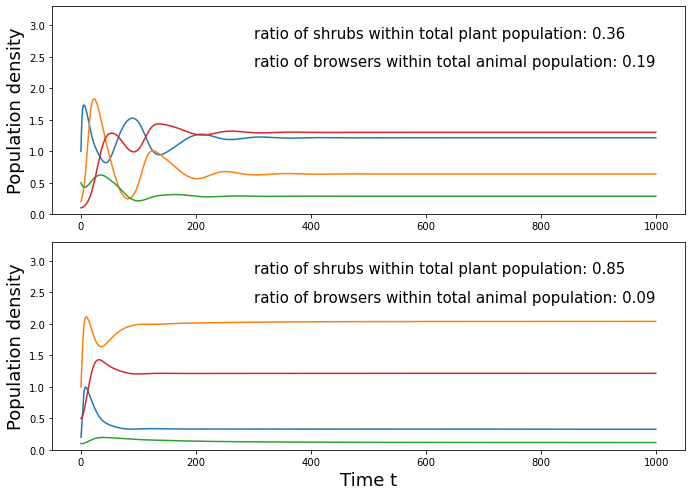

In [4]:
fb = 0.35  # farmer investment 1
fd = 0.0  # farmer investment 2

#--------------------------------------------------------------
# first time series:
x0 = [1.0, 0.2, 0.5, 0.1]        # initial population densities
X= integ.odeint(savannas,x0,t, args = (fb, fd))   # integrate the system
XP1 = X[:,0]                     # extract population densities
XP2 = X[:,1]
XC1 = X[:,2]
XC2 = X[:,3]

shrub_ratio_X = np.mean(XP2)/np.mean(XP1 + XP2)
browser_ratio_X = np.mean(XC1)/np.mean(XC1 + XC2)

print("Simulation 1: ")
print("Shrub ratio: ", shrub_ratio_X)
print("Browser ratio: ", browser_ratio_X)

#--------------------------------------------------------------
# second time series
y0 = [0.2, 1.0, 0.1, 0.5]        # initial population densities
Y= integ.odeint(savannas,y0,t, args = (fb, fd))   # integrate the system
YP1 = Y[:,0]                     # extract population densities
YP2 = Y[:,1]
YC1 = Y[:,2]
YC2 = Y[:,3]

shrub_ratio_Y = np.mean(YP2)/np.mean(YP1 + YP2)
browser_ratio_Y = np.mean(YC1)/np.mean(YC1 + YC2)
print("Simulation 2: ")
print("Shrub ratio: ", shrub_ratio_Y)
print("Browser ratio: ", browser_ratio_Y)

#---------------------------------------------------------------
# plot figure
plt.figure(figsize=(10,7))
tick_size = 12
label_size = 18

plt.style.use("default")
# plot first timeseries:
plt.subplot2grid((2,1), (0,0))

plt.plot(t, XP1, label = 'Grasses ($P_H$)')
plt.plot(t, XP2, label = 'Shrubs ($P_G$)')
plt.plot(t, XC1, label = 'Browsers ($C_H$)')
plt.plot(t, XC2, label = 'Grazers ($C_G$)')

plt.text(300,2.8,'ratio of shrubs within total plant population: 0.36', fontsize = 15)
plt.text(300,2.35,'ratio of browsers within total animal population: 0.19', fontsize = 15)

plt.ylim(0.0,3.3)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  #hide legend 
plt.ylabel("Population density", fontsize = label_size)

# plot second time series:
plt.subplot2grid((2,1), (1,0))

plt.plot(t, YP1, label = 'Grasses (P1)')
plt.plot(t, YP2, label = 'Shrubs (P2)')
plt.plot(t, YC1, label = 'Browsers (C1)')
plt.plot(t, YC2, label = 'Grazers (C2)')

plt.text(300,2.8,'ratio of shrubs within total plant population: 0.85', fontsize = 15)
plt.text(300,2.35,'ratio of browsers within total animal population: 0.09', fontsize = 15)

plt.ylim(0.0,3.3)
plt.xlabel("Time t", fontsize = label_size)
plt.ylabel("Population density", fontsize = label_size)

plt.tight_layout()

### 2.2 Visualing the bistable region in heatmaps

In [5]:
num_vals = 40                                   # number of values on the x- and y-axis
fb_vals = np.linspace(0.0,0.8,num_vals)         # farmer support (reduce mortality) - columns
fd_vals = np.linspace(0.0,0.8,num_vals)         # farmer support (reduce density dependent loss) - rows
shrub_ratio = np.zeros((num_vals,num_vals))     # empty matrix, containing only zeros
browser_ratio = np.zeros((num_vals,num_vals))   # another empty matrix, containing only zeros
survivors = np.zeros((num_vals,num_vals))       # a third matrix containing only zeros

for i in range(num_vals):                       # loop through row valus
    for j in range(num_vals):                   # loop through column valus
                
        fd = fd_vals[i]
        fb = fb_vals[j]
            
        # for each combination of fc and fx, first choose random initial population densities 
        x0 = [KH/2*rd.random(),KS*rd.random(),KS/5*rd.random(),KH/2*rd.random()]
                
        # then solve the system numerically
        X= integ.odeint(savannas,x0,t, args = (fb, fd))          
            
        # extract stationary part of the time series
        PH = X[-300:,0]
        PS = X[-300:,1]
        CB = X[-300:,2]
        CG = X[-300:,3]
        
        if PH[-1]>epsilon:
            survivors[i,j] = survivors[i,j] +1
        if PS[-1]>epsilon:
            survivors[i,j] = survivors[i,j] +1
        if CB[-1]>epsilon:
            survivors[i,j] = survivors[i,j] +1
        if CG[-1]>epsilon:
            survivors[i,j] = survivors[i,j] +1

        # calculate shrub ratio and browser ratio
        shrub_ratio[i,j] = np.mean(PS)/np.mean(PH + PS)
        browser_ratio[i,j]=  np.mean(CB)/np.mean(CB + CG)
        
    

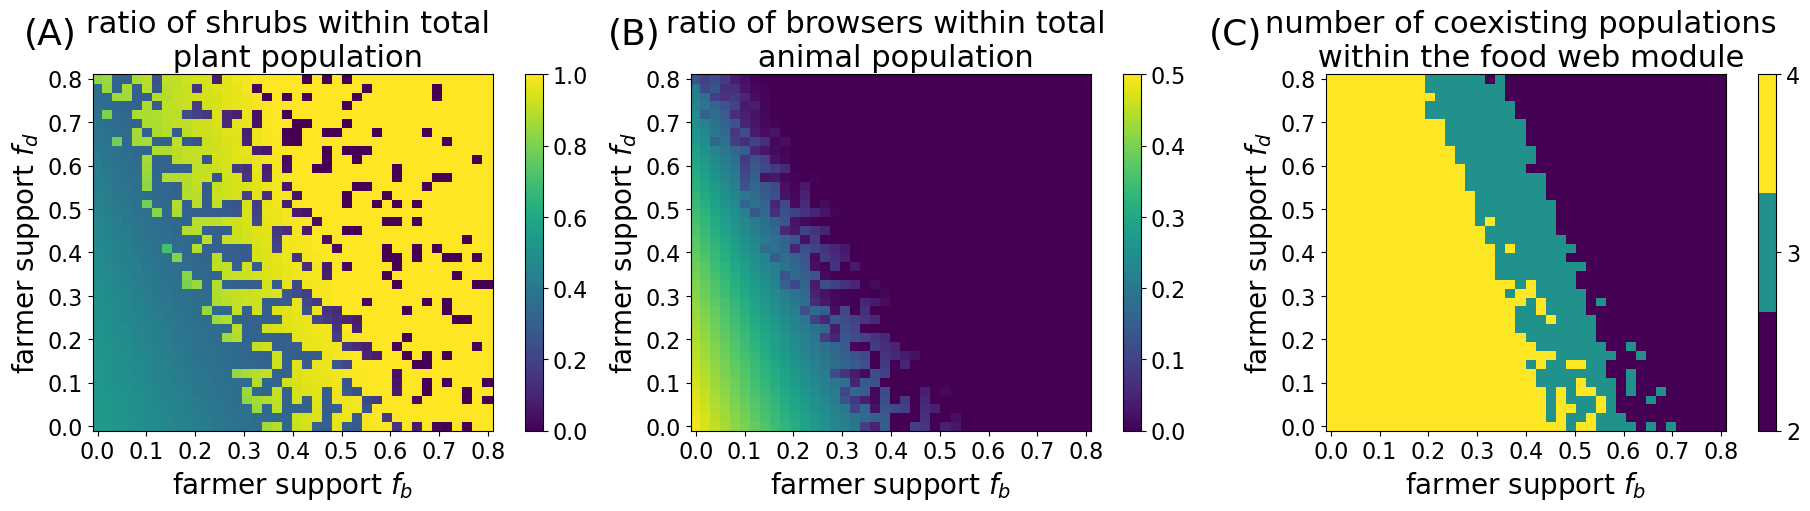

In [31]:
fig = plt.figure(figsize=(18,5), constrained_layout = True)

#set font sizes 
title_size = 22
label_size = 20
tick_size = 16

#initialise subplots 
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#first heatmap: shrub ratio
im = ax1.pcolor(fb_vals,fd_vals,shrub_ratio,vmin=0, vmax=1)             
ax1.set_title("ratio of shrubs within total \n plant population", fontsize = title_size)
ax1.set_xlabel('farmer support $f_{b}$', fontsize = label_size)
ax1.set_ylabel('farmer support $f_{d}$', fontsize = label_size);
plt.setp(ax1.get_xticklabels(), fontsize=tick_size)
plt.setp(ax1.get_yticklabels(), fontsize=tick_size)
cbar = plt.colorbar(im, ax = ax1)
cbar.ax.tick_params(labelsize = tick_size)
ax1.text(-0.15, 0.88, "(A)", fontsize=26)

#second heatmap: browser ratio
im = ax2.pcolor(fb_vals,fd_vals,browser_ratio,vmin=0, vmax=0.5)             
ax2.set_title("ratio of browsers within total \n animal population", fontsize = title_size)
ax2.set_xlabel('farmer support $f_{b}$', fontsize = label_size)
ax2.set_ylabel('farmer support $f_{d}$', fontsize = label_size);
plt.setp(ax2.get_xticklabels(), fontsize=tick_size)
plt.setp(ax2.get_yticklabels(), fontsize=tick_size)
cbar = plt.colorbar(im, ax = ax2)
cbar.ax.tick_params(labelsize = tick_size)
ax2.text(-0.18, 0.88, "(B)", fontsize=26)

#create discrete colorbar
my_cmap = plt.get_cmap("viridis", 3) 
norm = colors.BoundaryNorm(boundaries = [2, 3, 4], ncolors = 3)

#third heatmap: number of surviving populations
im = ax3.pcolor(fb_vals,fd_vals,survivors.astype(int), cmap = my_cmap)              
ax3.set_title("number of coexisting populations \n within the food web module", fontsize = title_size)
ax3.set_xlabel('farmer support $f_{b}$', fontsize = label_size)
ax3.set_ylabel('farmer support $f_{d}$', fontsize = label_size);
plt.setp(ax3.get_xticklabels(), fontsize=tick_size)
plt.setp(ax3.get_yticklabels(), fontsize=tick_size)
cbar = plt.colorbar(im, ax = ax3, norm = norm, ticks = [2,3,4])
cbar.ax.tick_params(labelsize = tick_size)

ax3.text(-0.25, 0.88, "(C)", fontsize=26)

#plt.tight_layout()
plt.show()  

fig.savefig("Fig2_heatmaps.pdf", dpi = 150)

### 2.3 Bifurcation diagrams for increasing farmer investment

Define helper function to extract the data we want:

In [7]:
def extract_data(X):
    
    # extract key data
    PH = X[-100:,0]
    PS = X[-100:,1]
    CB = X[-100:,2]
    CG = X[-100:,3]
    
    # append key data to lists 
    shrub_ratio = np.mean(PS)/np.mean(PH + PS)
    browser_ratio = np.mean(CB)/np.mean(CB + CG)
    
    return [min(PH), max(PH), min(PS), max(PS), min(CB), max(CB), min(CG), max(CG), shrub_ratio, browser_ratio]

Create data for two bifurcation diagrams: 
1. only $f_b$ is varied, $f_d$ is kept at 0 
2. both $f_b$ and $f_d$ are varied

In [158]:
#reset farmer investment values
fb = 0.0
fd = 0.0

# start with list for x-axis
f_list = np.arange(0.0,0.8,0.0005)

#initiliase empty lists list to store key data 
data_fb = []
data_fb_fd = []

#make longer time sereis
t_end = 3000 #end of the time series
t_step = 2 #stepsize
t = np.arange(0,t_end,t_step)

# now loop through f values
for f in f_list:
    
    # for each valus, first choose random initial population densities 
    x0 = [KH/5*rd.random(),KS/2*rd.random(),KS/5*rd.random(),KH/2*rd.random()]
    
    #-------------------------------------------------------------------------------------
    # data for first column - vary only fx:
    fb = f
    fd = 0
    
    # then solve the system numerically
    X= integ.odeint(savannas,x0,t, args = (fb, fd))
    #print(X)
    #data = extract_data(X) 
    #print(data)
    
    data_fb.append(extract_data(X))
    
    #------------------------------------------------------------------------------------
    # now redo the analysis for second column - vary both fx and fc:
    fb = f
    fd = f
    
    # then solve the system numerically
    X= integ.odeint(savannas,x0,t, args = (fb, fd))
    
    data_fb_fd.append(extract_data(X))
    # for each valus, first choose random initial population densities 
    x0 = [KH/5*rd.random(),KS/2*rd.random(),KS/5*rd.random(),KH/2*rd.random()]
    
#turn nested lists into data frames
col_names = ['min_PH', 'max_PH', 'min_PS', 'max_PS', 'min_CB', 'max_CB', 'min_CG', 'max_CG', 'shrub_ratio', 'browser_ratio']
data_fb = pd.DataFrame(data_fb, columns = col_names )
data_fb['f'] = f_list

data_fb_fd = pd.DataFrame(data_fb_fd, columns = col_names)
data_fb_fd['f'] = f_list

Plot both bifurcation diagrams in one figure: 

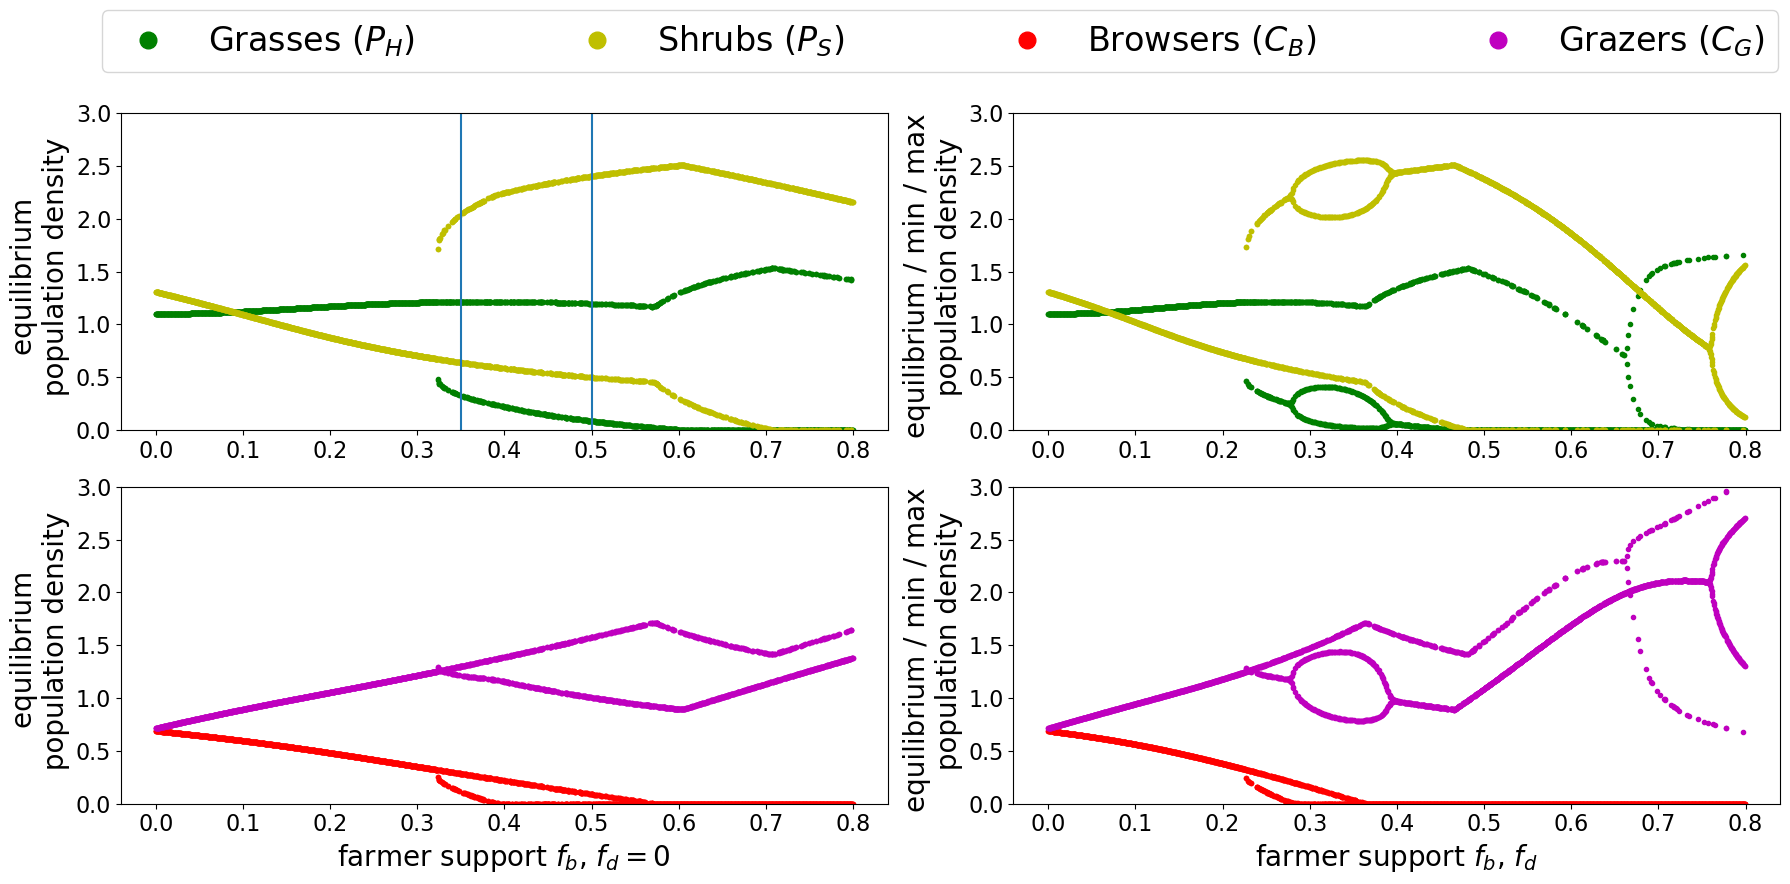

In [159]:
fig = plt.figure(figsize=(18,8))

# first column
plt.subplot2grid((2,2), (0,0))
plt.plot(data_fb['f'], data_fb['min_PH'], 'g.', label = 'Grasses ($P_H$)')
plt.plot(data_fb['f'], data_fb['max_PH'], 'g.')
plt.plot(data_fb['f'], data_fb['min_PS'], 'y.', label = 'Shrubs ($P_S$)')
plt.plot(data_fb['f'], data_fb['max_PS'], 'y.')
plt.ylim(0.0,3.0)
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
plt.axvline(x=0.35)
plt.axvline(x=0.50)
#plt.legend(bbox_to_anchor=(0.05, 0.9), loc=2, borderaxespad=0., fontsize = label_size)
plt.ylabel("equilibrium \n population density", fontsize = label_size)

plt.subplot2grid((2,2), (1,0))
plt.plot(data_fb['f'], data_fb['min_CB'], 'r.', label = 'Browsers ($C_B$)')
plt.plot(data_fb['f'], data_fb['max_CB'], 'r.')
plt.plot(data_fb['f'], data_fb['min_CG'], 'm.', label = 'Grazers ($C_G$)')
plt.plot(data_fb['f'], data_fb['max_CG'], 'm.')
plt.ylim(0.0,3.0)
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
#plt.legend(bbox_to_anchor=(0.05, 0.9), loc=2, borderaxespad=0.,  fontsize = label_size, markerscale = 3)
plt.ylabel("equilibrium \n population density", fontsize = label_size)
plt.xlabel("farmer support $f_b$, $f_d= 0$", fontsize = label_size)

#second column
plt.subplot2grid((2,2), (0,1))
plt.plot(data_fb_fd['f'], data_fb_fd['min_PH'], 'g.')
plt.plot(data_fb_fd['f'], data_fb_fd['max_PH'], 'g.')
plt.plot(data_fb_fd['f'], data_fb_fd['min_PS'], 'y.')
plt.plot(data_fb_fd['f'], data_fb_fd['max_PS'], 'y.')
plt.ylim(0.0,3.0)
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
#plt.legend(bbox_to_anchor=(1.05, 0.9), loc=2, borderaxespad=0.,  fontsize = label_size)
plt.ylabel("equilibrium / min / max \n population density", fontsize = label_size)

plt.subplot2grid((2,2), (1,1))
plt.plot(data_fb_fd['f'], data_fb_fd['min_CB'], 'r.')
plt.plot(data_fb_fd['f'], data_fb_fd['max_CB'], 'r.')
plt.plot(data_fb_fd['f'], data_fb_fd['min_CG'], 'm.')
plt.plot(data_fb_fd['f'], data_fb_fd['max_CG'], 'm.')
plt.ylim(0.0,3.0)
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
#plt.legend(bbox_to_anchor=(0.05, 0.9), loc=2, borderaxespad=0.,  fontsize = label_size)
plt.ylabel("equilibrium / min / max \n population density", fontsize = label_size)
plt.xlabel("farmer support $f_b$, $f_d$", fontsize = label_size)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
fig.legend(bbox_to_anchor=(0.05, 1, 0.95, 0), loc="lower left", mode="expand", ncol=4, fontsize = 24, markerscale = 4);
plt.tight_layout()
#plt.savefig("Fig2_bifurcation_diagram.pdf", bbox_inches='tight')
#should probably saved as raster graphic due to the number of points

Plot two seperate bifurcation diagrams

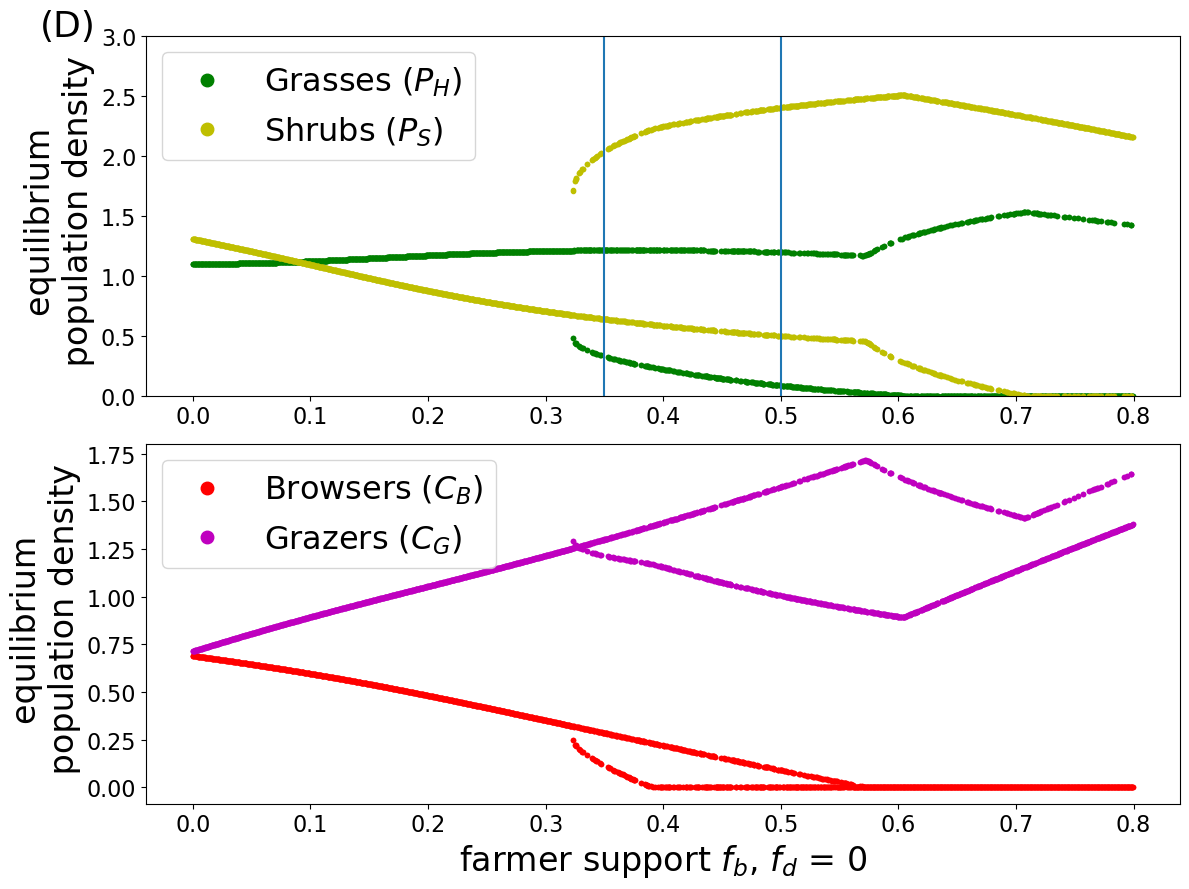

In [196]:
#split into two seperate figures 
#fig1: without fd

label_size = 24
fig = plt.figure(figsize=(12,9))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#subplot1: plants
ax1.plot(data_fb['f'], data_fb['min_PH'], 'g.', label = 'Grasses ($P_H$)')
ax1.plot(data_fb['f'], data_fb['max_PH'], 'g.')
ax1.plot(data_fb['f'], data_fb['min_PS'], 'y.', label = 'Shrubs ($P_S$)')
ax1.plot(data_fb['f'], data_fb['max_PS'], 'y.')
ax1.set_ylim(0.0,3.0)
plt.setp(ax1.get_xticklabels(), fontsize=tick_size)
plt.setp(ax1.get_yticklabels(), fontsize=tick_size)
ax1.legend(fontsize = label_size-1, markerscale = 3 )
ax1.axvline(x=0.35)
ax1.axvline(x=0.50)
ax1.set_ylabel("equilibrium \n population density", fontsize = label_size)


#subplot: herbivores
ax2.plot(data_fb['f'], data_fb['min_CB'], 'r.', label = 'Browsers ($C_B$)')
ax2.plot(data_fb['f'], data_fb['max_CB'], 'r.')
ax2.plot(data_fb['f'], data_fb['min_CG'], 'm.', label = 'Grazers ($C_G$)')
ax2.plot(data_fb['f'], data_fb['max_CG'], 'm.')
plt.setp(ax2.get_xticklabels(), fontsize=tick_size)
plt.setp(ax2.get_yticklabels(), fontsize=tick_size)
ax2.legend(fontsize = label_size-1, markerscale = 3)
ax2.set_ylabel("equilibrium \n population density", fontsize = label_size)
ax2.set_xlabel("farmer support $f_b$, $f_d$ = 0", fontsize = label_size)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
handles, labels = ax.get_legend_handles_labels()

ax1.text(-0.13, 3.0, "(D)", fontsize=26)

plt.tight_layout()

fig.savefig("Fig2_Bifurcation_fb.png")

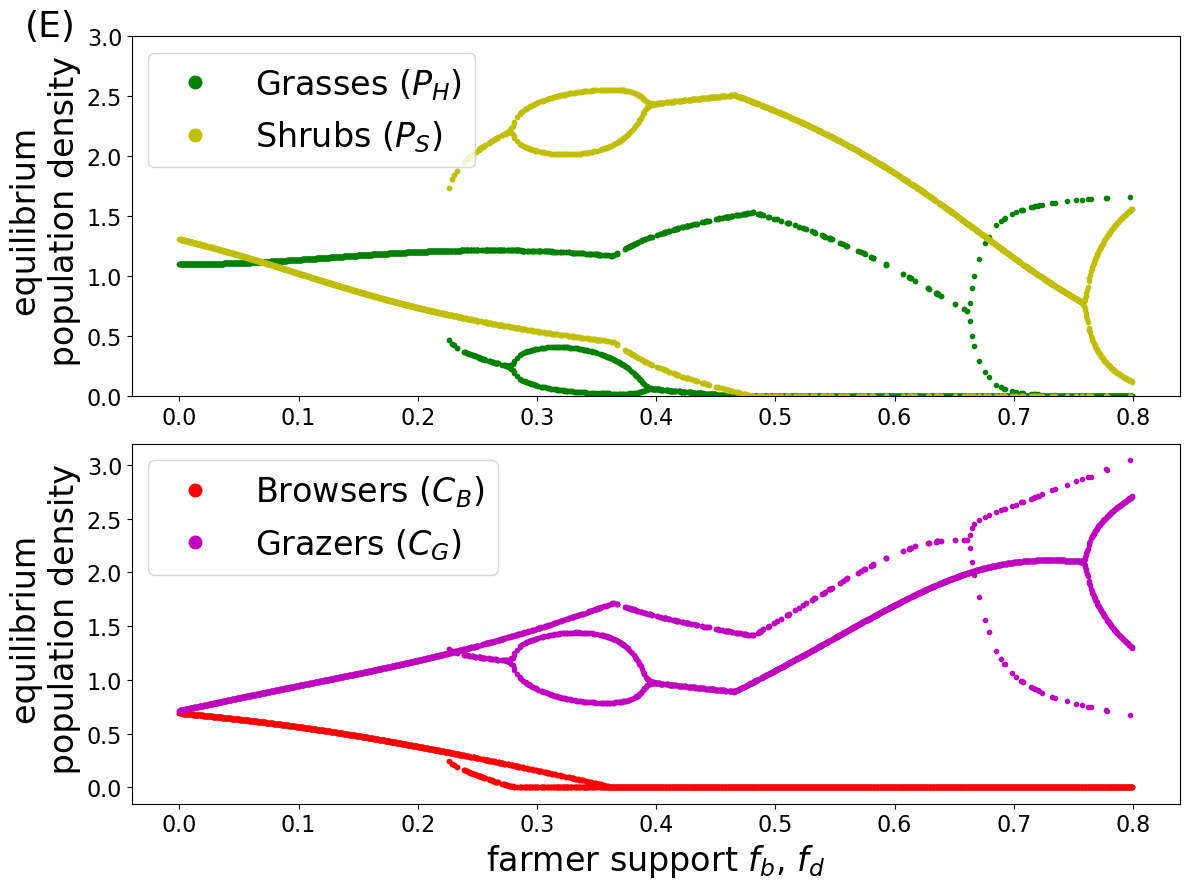

In [195]:
#split into two seperate figures 
#fig2: fb + fd

fig = plt.figure(figsize=(12,9))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#subplot1: plants
ax1.plot(data_fb_fd['f'], data_fb_fd['min_PH'], 'g.', label = 'Grasses ($P_H$)')
ax1.plot(data_fb_fd['f'], data_fb_fd['max_PH'], 'g.')
ax1.plot(data_fb_fd['f'], data_fb_fd['min_PS'], 'y.', label = 'Shrubs ($P_S$)')
ax1.plot(data_fb_fd['f'], data_fb_fd['max_PS'], 'y.')
ax1.set_ylim(0.0,3.0)
plt.setp(ax1.get_xticklabels(), fontsize=tick_size)
plt.setp(ax1.get_yticklabels(), fontsize=tick_size)
ax1.legend(loc = 2, fontsize = label_size, markerscale = 3 )
ax1.set_ylabel("equilibrium \n population density", fontsize = label_size)


#subplot: herbivores
ax2.plot(data_fb_fd['f'], data_fb_fd['min_CB'], 'r.', label = 'Browsers ($C_B$)')
ax2.plot(data_fb_fd['f'], data_fb_fd['max_CB'], 'r.')
ax2.plot(data_fb_fd['f'], data_fb_fd['min_CG'], 'm.', label = 'Grazers ($C_G$)')
ax2.plot(data_fb_fd['f'], data_fb_fd['max_CG'], 'm.')
plt.setp(ax2.get_xticklabels(), fontsize=tick_size)
plt.setp(ax2.get_yticklabels(), fontsize=tick_size)
ax2.legend(fontsize = label_size, markerscale = 3)
ax2.set_ylabel("equilibrium \n population density", fontsize = label_size)
ax2.set_xlabel("farmer support $f_b$, $f_d$", fontsize = label_size)

lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
handles, labels = ax.get_legend_handles_labels()

ax1.text(-0.13, 3.0, "(E)", fontsize=26)

plt.tight_layout()

fig.savefig("Fig2_Bifurcation_fd_fb.png")

## 3. Transitions between states

In [11]:
def simulate_droughts(sections_number, season_length, N0 , f_values, d_values, introduce_browsers):
    
    """
    Splits the simulation in a number of sections, that are seperated by drought events that kill d% of grasses ans d/5 % of shrubs
    f can be varied for each section
    """
    
    #check if f_values, d_values and introduce_browsers have n = section number entries
    if len(f_values)!= sections_number: print("Incorrect number of f values")
    if len(d_values)!= sections_number: print("Incorrect number of d values")                                   
    if len(introduce_browsers)!= sections_number: print("Incorrect number of introduce browsers")
   
    #prepare timesteps array for one section of the time series
    time = np.arange(0, season_length)

    #prepare matrices to store results
    #N will contain the results for all populations at each timestep
    num_rows = sections_number*(len(time))+sections_number+1 #number of rows that N needs to have to store everything

    N = np.zeros([num_rows, 4])
    N[0,:] = N0

    count = 0 #counts how many growing seasons have been completed
    t = 1 # used to index N/counting all time steps

    while count < sections_number :

        x0 = N[t-1, :]
         
        fb = f_values[count]
        
        X = integ.odeint(savannas, x0, time, args = (fb,fd))
        
        #put X into N
        N[t:t+len(time), :] = X

        #update index
        t = t+len(time)
        
        ##DROUGHT!
        #calculate the amount of biomass that survives
        PH = X[-1,0]*(1-d_values[count])
        PS = X[-1,1]*(1-0.2*d_values[count])
        C1 = X[-1,2]
        C2 = X[-1,3]
        
        ##Reintroduction of BROWSERS!
        if (C1< epsilon and introduce_browsers[count] == True):
            #reintroduce a small number of browsers to the system
            C1 = 0.01
            
        #define new N for t
        N[t,:] = np.array([PH, PS, C1,C2])

        #update index and counter
        count = count + 1
        t = t+1
    
    return N

### 3.1 Moderate increase of farmer support

The time series is split into six section
1. $f_b = 0$ $\rightarrow$ system reaches equilibrium. After 1000 timesteps, there is a **drought** with severity 0.95
2. $f_b = 0$ $\rightarrow$ the system recovers quickly from the drought and goes back to the same equilibrium as before
3. $f_b = 0.35$ $\rightarrow$ farmer support is increased, the system reaches a new equilibrium. After 1000 timesteps, there is a **drought** with severity 0.95
4. $f_b = 0.35$ $\rightarrow$ the system transitions to the encroached state
5. $f_b = 0$ $\rightarrow$ farmer support is reduced but the system stays in the encroached state
6. $f_b = 0$ $\rightarrow$ browsers are reintroduced, the system is then able to go back to the unencroached state



In [18]:
#go back to shorter time series
t_end = 1000 #end of the time series
t_step = 1 #stepsize
t = np.arange(0,t_end,t_step)

sections_number = 6  #number of disturbances
season_length = 1000 #number timesteps between droughts

N0 = [KH/2*rd.random(),KS/10*rd.random(),KH/5*rd.random(),KS/2*rd.random()] #initial population densities
#N0 = [1,1,1,1]
#each value in the list describes what happens at the end of the corresponding section
f_values = [0, 0, 0.35, 0.35, 0, 0]
d_values = [0.95, 0, 0.95, 0, 0, 0]
introduce_browsers = [0,0,0,0,1,0]

N_total = simulate_droughts(sections_number, season_length, N0, f_values, d_values, introduce_browsers)
N_total = pd.DataFrame(N_total, columns = ['PH', 'PS', 'CB', 'CG'])
N_total['time'] = np.arange(N_total.shape[0])


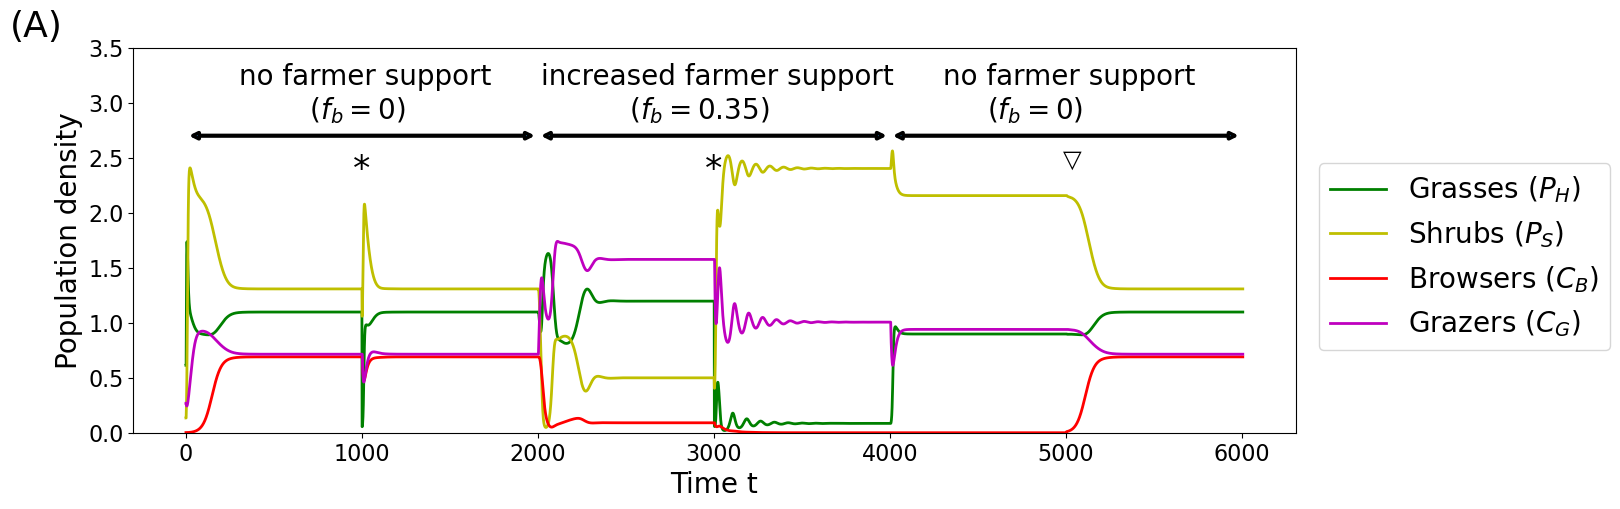

In [138]:
fig = plt.figure(figsize=(15,5))

plt.plot(N_total['time'], N_total['PH'],"g",  label = "Grasses ($P_H$)", linewidth = 2)
plt.plot(N_total['time'], N_total['PS'], "y", label = "Shrubs ($P_S$)", linewidth = 2)
plt.plot(N_total['time'], N_total['CB'], "r", label = "Browsers ($C_B$)", linewidth = 2)
plt.plot(N_total['time'], N_total['CG'], "m", label = "Grazers ($C_G$)", linewidth = 2)

plt.ylim(0.0,3.5)
#plt.xlim(0, 6000)
plt.legend(bbox_to_anchor=(1.02, 0.7), loc=2, borderaxespad=0., fontsize = label_size)
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
plt.xlabel("Time t", fontsize = label_size)
plt.ylabel("Population density", fontsize = label_size)

# add arrows and labels:
#ax = plt.axes()
arrow_placement = 2.7
text_placement = 2.85
plt.annotate('', xy=(0,arrow_placement),
            xytext=(2000,arrow_placement), va='center', multialignment='center',
            arrowprops={'arrowstyle': '<|-|>', 'lw': 3, 'ec': 'k'})
plt.text(300, text_placement, 'no farmer support \n        ($f_{b}=0$)', fontsize = label_size)

plt.annotate('', xy=(2000,arrow_placement),
            xytext=(4000,arrow_placement), va='center', multialignment='center',
            arrowprops={'arrowstyle': '<|-|>', 'lw': 3, 'ec': 'k'})
plt.text(2020, text_placement, 'increased farmer support\n          ($f_{b}=0.35$)', fontsize = label_size)

plt.annotate('', xy=(4000, arrow_placement),
            xytext=(6000,arrow_placement), va='center', multialignment='center',
            arrowprops={'arrowstyle': '<|-|>', 'lw': 3, 'ec': 'k'})
plt.text(4300, text_placement, 'no farmer support \n     ($f_{b}=0)$', fontsize = label_size)

plt.text(950, 2.3, r'*', fontsize='25')
plt.text(2950, 2.3, r'*', fontsize='25');
plt.text(4950, 2.3, r'$^\bigtriangledown$', fontsize='25')

#add panel identifier
plt.text(-1000, 3.6, "(A)", fontsize=26)
plt.savefig("Fig3_timeseries1.pdf", dpi = 150, bbox_inches='tight')

### 3.2 Strong increase of farmer support

The time series is split into six section
1. $f_b = 0$ $\rightarrow$ system reaches equilibrium. After 1000 timesteps, there is a **drought** with severity 0.95
2. $f_b = 0$ $\rightarrow$ the system recovers quickly from the drought and goes back to the same equilibrium as before
3. $f_b = 0.5$ $\rightarrow$ farmer support is increased, the system reaches a new equilibrium. After 1000 timesteps, there is a **drought** with severity 0.95
4. $f_b = 0.5$ $\rightarrow$ the system transitions to the encroached state
5. $f_b = 0$ $\rightarrow$ farmer support is reduced but the system stays in the encroached state
6. $f_b = 0$ $\rightarrow$ browsers are reintroduced, the system is then able to go back to the unencroached state


In [20]:
sections_number = 6  #number of disturbances
season_length = 1000 #number timesteps between droughts

N0 = [KH/2*rd.random(),KS/10*rd.random(),KH/5*rd.random(),KS/2*rd.random()] #initial population densities
#N0 = [1,1,1,1]
#each value in the list describes what happens at the end of the corresponding section
f_values = [0, 0, 0.5, 0.5, 0, 0]
d_values = [0.95, 0, 0.95, 0, 0, 0]
introduce_browsers = [0,0,0,0,1,0]

N_total = simulate_droughts(sections_number, season_length, N0, f_values, d_values, introduce_browsers)
N_total = pd.DataFrame(N_total, columns = ['PH', 'PS', 'CB', 'CG'])
N_total['time'] = np.arange(N_total.shape[0])


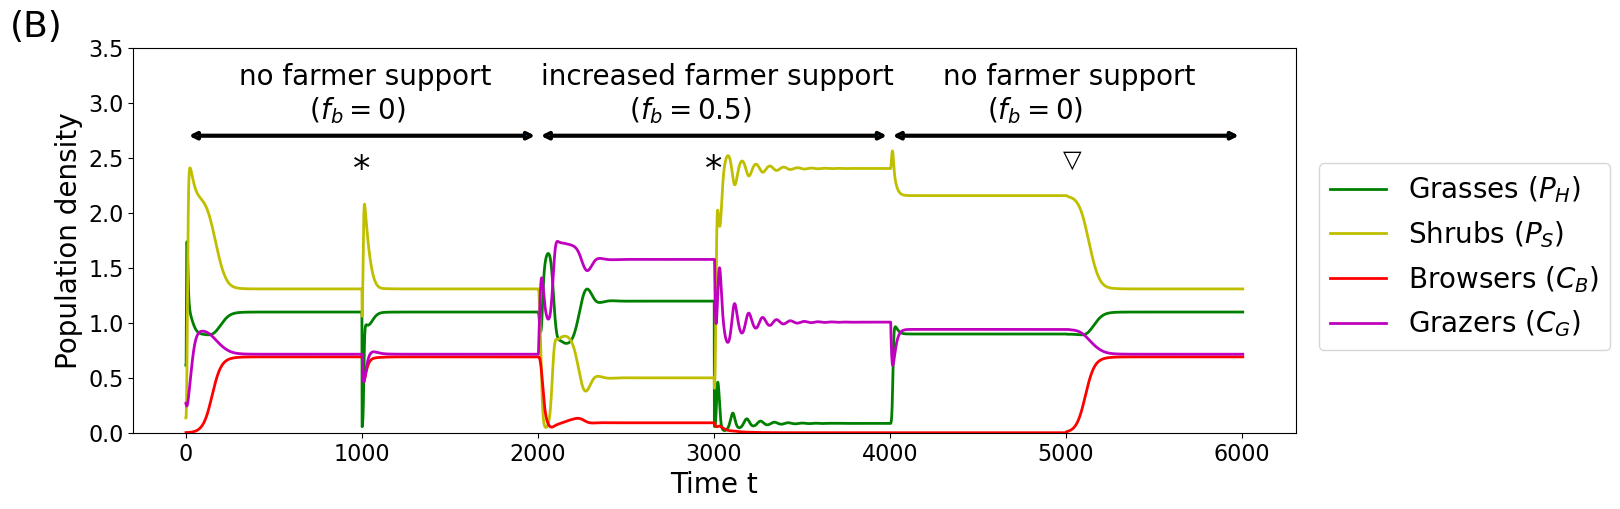

In [137]:
fig = plt.figure(figsize=(15,5))

plt.plot(N_total['time'], N_total['PH'],"g", label = "Grasses ($P_H$)", linewidth = 2)
plt.plot(N_total['time'], N_total['PS'], "y",  label = "Shrubs ($P_S$)",  linewidth = 2)
plt.plot(N_total['time'], N_total['CB'], "r", label = "Browsers ($C_B$)",  linewidth = 2)
plt.plot(N_total['time'], N_total['CG'], "m", label = "Grazers ($C_G$)",  linewidth = 2)

plt.ylim(0.0,3.5)
plt.legend(bbox_to_anchor=(1.02, 0.7), loc=2, borderaxespad=0., fontsize = label_size)

plt.xlabel("Time t", fontsize = label_size)
plt.ylabel("Population density", fontsize = label_size)

plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)

# add arrows and labels:
#ax = plt.axes()
plt.annotate('', xy=(0,arrow_placement),
            xytext=(2000,arrow_placement), va='center', multialignment='center',
            arrowprops={'arrowstyle': '<|-|>', 'lw': 3, 'ec': 'k'})
plt.text(300, text_placement, 'no farmer support \n        ($f_{b}=0$)', fontsize = label_size)

plt.annotate('', xy=(2000,arrow_placement),
            xytext=(4000,arrow_placement), va='center', multialignment='center',
            arrowprops={'arrowstyle': '<|-|>', 'lw': 3, 'ec': 'k'})
plt.text(2020, text_placement, 'increased farmer support\n          ($f_{b}=0.5$)', fontsize = label_size)

plt.annotate('', xy=(4000, arrow_placement),
            xytext=(6000,arrow_placement), va='center', multialignment='center',
            arrowprops={'arrowstyle': '<|-|>', 'lw': 3, 'ec': 'k'})
plt.text(4300, text_placement, 'no farmer support \n     ($f_{b}=0)$', fontsize = label_size)


plt.text(950, 2.3, r'*', fontsize='25')
plt.text(2950, 2.3, r'*', fontsize='25')
plt.text(4950, 2.3, r'$^\bigtriangledown$', fontsize='25')

#add oanel identifier
plt.text(-1000, 3.6, "(B)", fontsize=26)

plt.savefig("Fig3_timeseries2.pdf", dpi = 150, bbox_inches='tight')

## 4. Analysing resistance to drought

In [16]:
#reset farmer support values
fd=0
fb=0.3

x0 = [KH/2*rd.random(),KS/5*rd.random(),KH/5*rd.random(),KS/2*rd.random()]

reference = integ.odeint(savannas,x0,t, args = (fb, fd))   # end point of this time series are used as starting points below


num_vals = 40                                        # number of values on the x- and y-axis
f_vals = np.linspace(0.0,0.8,num_vals)               # farmer investment (reduce background mortality) - columns
disturbance_vals = np.linspace(50,99,num_vals)      # severity of droughts - rows

#initialise empty matrices to fill
shrub_ratio_new = np.zeros((num_vals,num_vals))      # empty matrix, containing only zeros
browser_ratio_new = np.zeros((num_vals,num_vals))    # another empty matrix, containing only zeros
grazer_absolute_new = np.zeros((num_vals,num_vals))  # a third empty matrix, containing only zeros

for i in range(num_vals):                       # loop through row valus -> disturbance
    for j in range(num_vals):                   # loop through column values -> farmer support fb
        

        disturbance = disturbance_vals[i]      
        fb = f_vals[j]
            
        # for each combination of parameter values, first choose random initial population densities 
        x0 = [reference[-1,0], reference[-1,1], reference[-1,2], reference[-1,3]]
        
        # then let the system run for a while to reach an attractor
        X0 = integ.odeint(savannas,x0,t, args = (fb, fd))

        PH_0 = X0[:,0]
        PS_0 = X0[:,1]
        CB_0 = X0[:,2]
        CG_0 = X0[:,3]
        
        # then perform disturbance and let the system run for another while
        # disturbance level of d means that the drought kills d% of grass biomass and d/5% of shrub biomass
        x0_new = [PH_0[-1]*(1-disturbance/100), PS_0[-1]*(1-disturbance/(5*100)), CB_0[-1], CG_0[-2]]   # new initial population densities
        X1 = integ.odeint(savannas,x0_new,t, args = (fb, fd))

        # extract stationary part of the time series
        PH_1 = X1[-300:,0]
        PS_1 = X1[-300:,1]
        CB_1 = X1[-300:,2]
        CG_1 = X1[-300:,3]

        # calculate shrub ratio and browser ratio
        shrub_ratio_new[i,j] = np.mean(PS_1)/np.mean(PH_1 + PS_1)
        browser_ratio_new[i,j] = np.mean(CB_1)/np.mean(CB_1 + CG_1)
        grazer_absolute_new[i,j] = np.mean(CG_1)
        


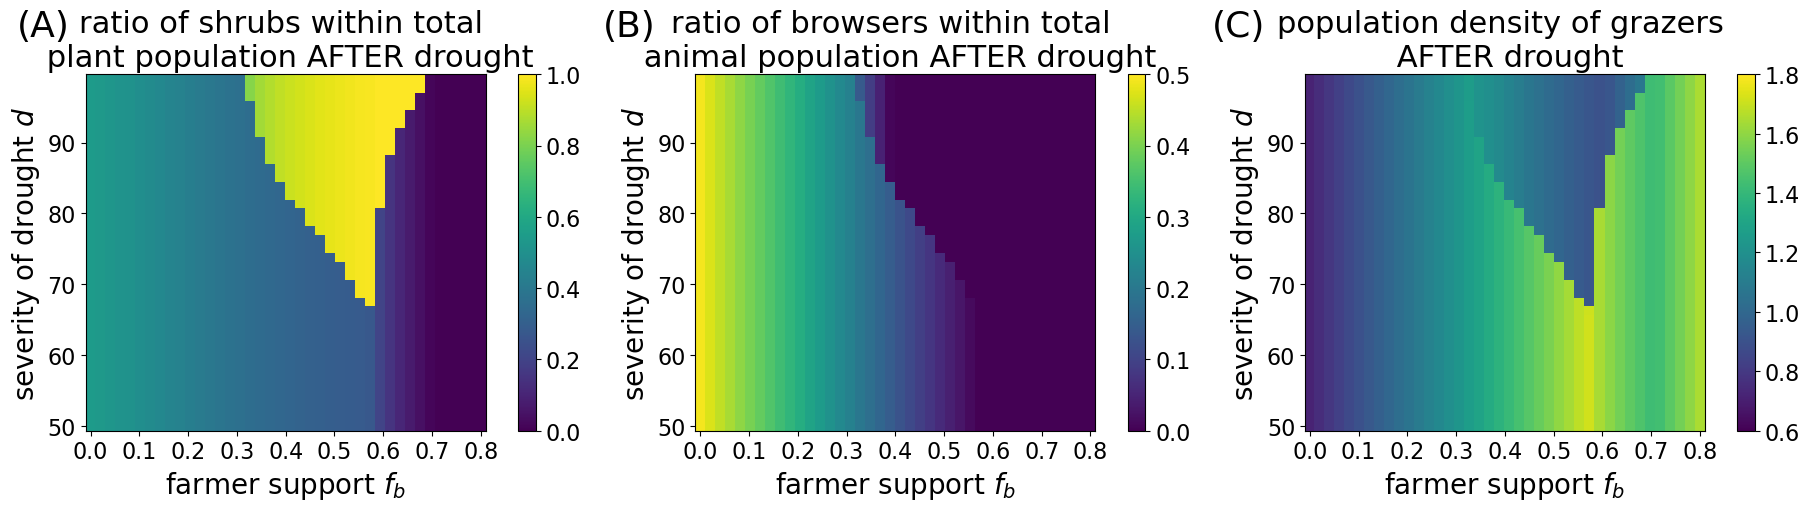

In [152]:
# plot heatmaps
fig = plt.figure(figsize=(18,5), constrained_layout = True)

#1. Heatmap: Shrub ratio
plt.subplot2grid((1,3), (0,0))
plt.pcolor(f_vals,disturbance_vals,shrub_ratio_new,vmin=0, vmax=1)            

plt.title("ratio of shrubs within total \n plant population AFTER drought", fontsize = title_size)
plt.xlabel('farmer support $f_{b}$', fontsize = label_size)
plt.ylabel('severity of drought $d$', fontsize = label_size);
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = tick_size)
plt.text(-0.15, 105, "(A)", fontsize=26)

#2. Heatmap: Browser ratio
plt.subplot2grid((1,3), (0,1))
plt.pcolor(f_vals,disturbance_vals,browser_ratio_new,vmin=0, vmax=0.5)             
plt.title("ratio of browsers within total \n animal population AFTER drought", fontsize = title_size)
plt.xlabel('farmer support $f_{b}$', fontsize = label_size)
plt.ylabel('severity of drought $d$', fontsize = label_size);
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = tick_size)
plt.text(-0.2, 105, "(B)", fontsize=26)

#3. Heatmap: grazer density
plt.subplot2grid((1,3), (0,2))
plt.pcolor(f_vals,disturbance_vals,grazer_absolute_new,vmin=0.6, vmax=1.8)              
plt.title("population density of grazers \n AFTER drought", fontsize = title_size)
plt.xlabel('farmer support $f_{b}$', fontsize = label_size)
plt.ylabel('severity of drought $d$', fontsize = label_size);
plt.yticks(fontsize = tick_size)
plt.xticks(fontsize = tick_size)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = tick_size)
plt.text(-0.2, 105, "(C)", fontsize=26)

#plt.tight_layout()
plt.show()  

fig.savefig("Fig4_heatmap_drought_resistance.pdf", dpi = 150)